In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

#https://developers.google.com/earth-engine/datasets/catalog/GRIDMET_DROUGHT

In [2]:
##Modeling
df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_120822.csv')

df1.rename(columns={'elevation':'Elevation'}, inplace=True)
# df1 = df1[df1['ident'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1)] ##TIDAL FILTERING STEP!

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

df1['Date'] = pd.to_datetime(df1.Date, format='%m/%d/%Y')
df1['DOY'] = df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset
# df1['DOY'] = df1['Date'].dt.strftime('%j').astype('float') ##The astype('float') is only for the regression - not for ML 

xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin', 
        'ndvi_year', 'nd_swir2_r_year', 'nd_swir2_nir_year', 'nd_g_b_year','wdrvi5_year', 'savi_year', 'tmax', 'tmin',
        'ndvi_peak', 'nd_swir2_r_peak', 'nd_swir2_nir_peak', 'nd_g_b_peak','wdrvi5_peak', 'savi_peak', 'tmax_peak', 'tmin_peak'
    ]
]

yargs=df1['Plant_Biomass'] 

##NEED SEASONAL DAYMET DATA
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

In [3]:
#Random forest

#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)


# Mean baseline
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

MEAN BASELINE:
Mean Absolute Error: 438.0519261351442
Root Mean Squared Error: 637.9415834095377


In [4]:
##5-fold cross validation
predictors = xargs_train
targets = yargs_train 

from sklearn.model_selection import KFold, cross_validate

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

x = pd.DataFrame(cv_results)

print('r squared is: ' + str(x['test_r2'].mean()))
print('Average RMSE (5 fold) is: '+ str(-x['test_neg_root_mean_squared_error'].mean()))
print('NRSME is: ' + str(-x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))

r squared is: 0.3850826331893832
Average RMSE (5 fold) is: 463.699107861156
NRSME is: 0.11416728576817373


In [5]:
#xgboost
from xgboost import XGBClassifier, XGBRegressor

#Linear_model
pipe2 = Pipeline([('scaler', StandardScaler()), ('xgboost', XGBRegressor())])
# pipe2 = Pipeline([('scaler', MinMaxScaler()), ('regr', linear_model.LinearRegression())])

pipe2.fit(xargs_train, yargs_train)
y_pred_reg=pipe2.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))

##k-fold cross validation
predictors = xargs_train
targets = yargs_train 

from sklearn.model_selection import KFold, cross_validate

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe2
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

x = pd.DataFrame(cv_results)

print(x['test_r2'].mean())
print('Average RMSE (5 fold) is: '+ str(x['test_neg_root_mean_squared_error'].mean()))
print('NRSME is: ' + str(x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))


Mean Absolute Error: 345.4018807764797
0.2206265618280269
Average RMSE (5 fold) is: -510.96799442810817
NRSME is: -0.12580535103322163


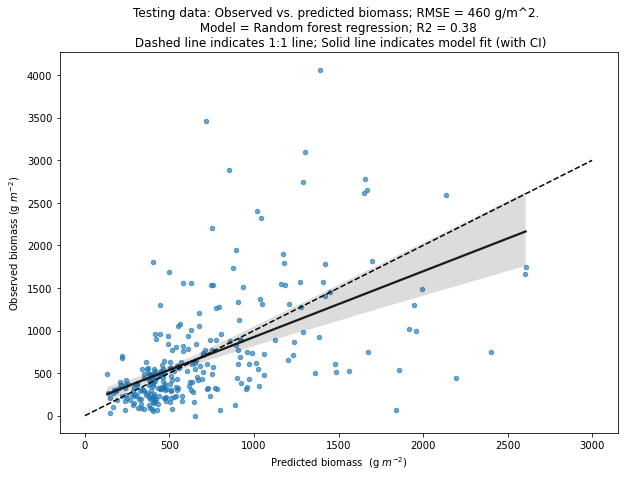

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#Random forest model evaluation

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

points = plt.scatter(x=y_pred, y=yargs_test, s=20, cmap="BuGn", alpha=0.65)
sns.regplot(x = y_pred, y=yargs_test, scatter=False, color=".1").set(
    xlabel='Predicted biomass  (g $m^{-2}$)', ylabel='Observed biomass (g $m^{-2}$)', 
    title="Testing data: Observed vs. predicted biomass; RMSE = 460 g/m^2. \n Model = Random forest regression; R2 = 0.38 \n Dashed line indicates 1:1 line; Solid line indicates model fit (with CI)"
)

plt.plot([0, 3000], [0, 3000], 'k--')



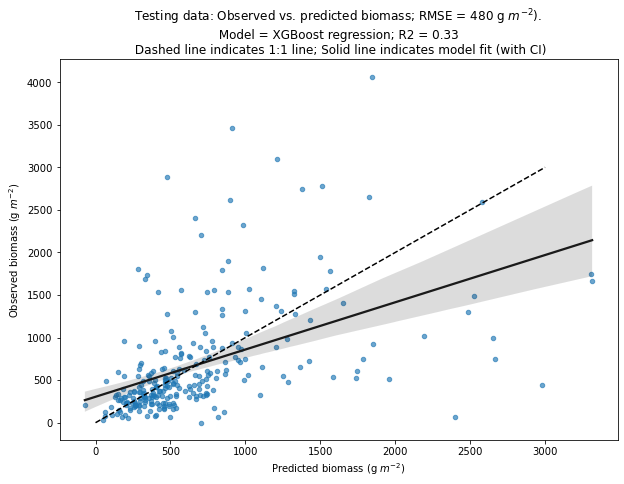

In [7]:
#Linear regression model evaluation

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

points = plt.scatter(x=y_pred_reg, y=yargs_test, s=20, cmap="BuGn", alpha=0.65)
sns.regplot(x = y_pred_reg, y=yargs_test, scatter=False, color=".1").set(
    xlabel='Predicted biomass (g $m^{-2}$)', ylabel='Observed biomass (g $m^{-2}$)', 
    title="Testing data: Observed vs. predicted biomass; RMSE = 480 g $m^{-2}$). \n Model = XGBoost regression; R2 = 0.33 \n Dashed line indicates 1:1 line; Solid line indicates model fit (with CI)"
)

plt.plot([0, 3000], [0, 3000], 'k--')

